In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from hyperopt.mongoexp import MongoTrials
from keras.constraints import maxnorm

Using TensorFlow backend.


In [2]:
import numpy
import tensorflow

numpy.random.seed(7)
tensorflow.set_random_seed(2)

In [3]:
data_points = 100
train_data_0 = np.random.uniform(-10, 10, data_points)

mu_train_0, sigma_train_0 = 0, 0
noise_train_0 = np.random.normal(mu_train_0, sigma_train_0, data_points)

train_labels_0_pre = np.power(train_data_0, 3) + noise_train_0

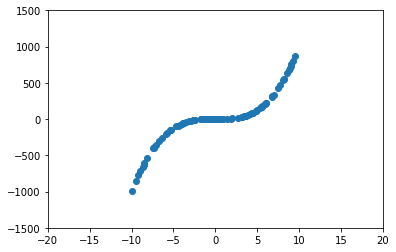

In [4]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_0, train_labels_0_pre)
plt.show()

In [5]:
order = np.argsort(np.random.random(train_labels_0_pre.shape))

pre_train_data_0 = np.array(train_data_0[order]).reshape(data_points, 1)
train_labels_0 = np.array(train_labels_0_pre[order]).reshape(data_points, 1)

mean = pre_train_data_0.mean(axis=0)
std = pre_train_data_0.std(axis=0)

post_train_data_0 = (pre_train_data_0 - mean) / std

In [16]:
unit_numbers = np.linspace(1, 10, 6, dtype=int)
unit_activations = [tf.keras.activations.relu, tf.keras.activations.selu, tf.keras.activations.tanh, 
                    tf.keras.activations.sigmoid, tf.keras.activations.hard_sigmoid]
optimizers = [tf.train.RMSPropOptimizer(learning_rate=0.5), 
              tf.train.AdamOptimizer(1e-4)]
dropout = np.linspace(0.1, 0.5, 6, dtype=float)

In [20]:
space = {
    'choice': hp.choice('layers_number', [{'layers': 'two'}, 
                                          {'layers': 'three',     
                                           'units_3': hp.choice('units_3', unit_numbers),
                                            'units_3_activation': 
                                               hp.choice('units_3_activation', unit_activations),
                                           'dropout_3': hp.choice('dropout_3', dropout)
                                          },
                                              {'layers': 'four',     
                                           'units_4': hp.choice('units_4', unit_numbers),
                                            'units_4_activation': 
                                               hp.choice('units_4_activation', unit_activations),
                                           'dropout_4': hp.choice('dropout_4', dropout)
                                              },
                                            {'layers': 'five',     
                                           'units_5': hp.choice('units_5', unit_numbers),
                                            'units_5_activation': 
                                               hp.choice('units_5_activation', unit_activations),
                                           'dropout_5': hp.choice('dropout_5', dropout)
                                              }]),
    'units_1': hp.choice('units_1', unit_numbers),
    'units_1_activation': hp.choice('units_1_activation', unit_activations),
    'dropout_1': hp.choice('dropout_1', dropout),
    'units_2': hp.choice('units_2', unit_numbers),
    'units_2_activation': hp.choice('units_2_activation', unit_activations),
    'optimizer': hp.choice('optimizer', optimizers) 
}

In [25]:
def build_model_hopt(params):
    print(params)
    EPOCHS = 800
    model = keras.Sequential()
    model.add(keras.layers.Dense(params['units_1'], activation=params['units_1_activation'],
                       input_shape=(post_train_data_0.shape[1],), kernel_constraint=maxnorm(3)))
    model.add(keras.layers.Dropout(params['dropout_1']))
    model.add(keras.layers.Dense(params['units_2'], activation=params['units_2_activation'], 
                                 kernel_constraint=maxnorm(3)))
        
    if params['choice']['layers'] == 'three':
        model.add(keras.layers.Dense(params['choice']['units_3'])) 
        model.add(keras.layers.Dropout(params['choice']['dropout_3']))
    
    if params['choice']['layers'] == 'four':
        model.add(keras.layers.Dense(params['choice']['units_4'])) 
        model.add(keras.layers.Dropout(params['choice']['dropout_4']))
    
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse',
                optimizer=params['optimizer'],
                metrics=['mae'])
    

    model.fit(post_train_data_0, train_labels_0, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)
    
    predicted_0 = model.predict(train_data_0).reshape(data_points, 1)
    
    acc = np.square(np.subtract(predicted_0, train_labels_0_pre)).mean()

    return {'loss': -acc, 'status': STATUS_OK}

{'choice': {'dropout_3': 0.18, 'layers': 'three', 'units_3_activation': <function sigmoid at 0x7fc657e60bf8>, 'units_3': 2}, 'units_1': 1, 'units_1_activation': <function selu at 0x7fc5f4fc2c80>, 'dropout_1': 0.33999999999999997, 'optimizer': <tensorflow.python.training.adam.AdamOptimizer object at 0x7fc3be623f60>, 'units_2': 4, 'units_2_activation': <function sigmoid at 0x7fc657e60bf8>}
Train on 80 samples, validate on 20 samples
Epoch 1/800
80/80 [==============================] - 1s 16ms/step - loss: 94509.6500 - mean_absolute_error: 183.4874 - val_loss: 176577.9688 - val_mean_absolute_error: 294.8390
Epoch 2/800
80/80 [==============================] - 0s 144us/step - loss: 94494.9391 - mean_absolute_error: 183.5332 - val_loss: 176575.5938 - val_mean_absolute_error: 294.8380
Epoch 3/800
80/80 [==============================] - 0s 154us/step - loss: 94481.0141 - mean_absolute_error: 183.5317 - val_loss: 176572.9531 - val_mean_absolute_error: 294.8353
Epoch 4/800
80/80 [=============

80/80 [==============================] - 0s 142us/step - loss: 94494.0234 - mean_absolute_error: 183.4372 - val_loss: 176504.0469 - val_mean_absolute_error: 294.7935
Epoch 45/800
80/80 [==============================] - 0s 140us/step - loss: 94457.2812 - mean_absolute_error: 183.4605 - val_loss: 176502.9062 - val_mean_absolute_error: 294.7928
Epoch 46/800
80/80 [==============================] - 0s 127us/step - loss: 94415.3891 - mean_absolute_error: 183.3309 - val_loss: 176501.7344 - val_mean_absolute_error: 294.7923
Epoch 47/800
80/80 [==============================] - 0s 119us/step - loss: 94495.6219 - mean_absolute_error: 183.4417 - val_loss: 176500.5625 - val_mean_absolute_error: 294.7914
Epoch 48/800
80/80 [==============================] - 0s 136us/step - loss: 94455.7875 - mean_absolute_error: 183.4630 - val_loss: 176499.4219 - val_mean_absolute_error: 294.7908
Epoch 49/800
80/80 [==============================] - 0s 112us/step - loss: 94408.8063 - mean_absolute_error: 183.3218

Epoch 90/800
80/80 [==============================] - 0s 175us/step - loss: 94415.4773 - mean_absolute_error: 183.3279 - val_loss: 176462.3750 - val_mean_absolute_error: 294.7709
Epoch 91/800
80/80 [==============================] - 0s 116us/step - loss: 94448.0844 - mean_absolute_error: 183.4404 - val_loss: 176461.6094 - val_mean_absolute_error: 294.7705
Epoch 92/800
80/80 [==============================] - 0s 127us/step - loss: 94386.6156 - mean_absolute_error: 183.2485 - val_loss: 176460.8438 - val_mean_absolute_error: 294.7704
Epoch 93/800
80/80 [==============================] - 0s 112us/step - loss: 94471.5656 - mean_absolute_error: 183.4096 - val_loss: 176460.0469 - val_mean_absolute_error: 294.7700
Epoch 94/800
80/80 [==============================] - 0s 156us/step - loss: 94341.5680 - mean_absolute_error: 183.2943 - val_loss: 176459.2969 - val_mean_absolute_error: 294.7697
Epoch 95/800
80/80 [==============================] - 0s 172us/step - loss: 94328.9250 - mean_absolute_er

80/80 [==============================] - 0s 139us/step - loss: 94395.9187 - mean_absolute_error: 183.3498 - val_loss: 176429.0938 - val_mean_absolute_error: 294.7552
Epoch 136/800
80/80 [==============================] - 0s 119us/step - loss: 94466.7188 - mean_absolute_error: 183.4396 - val_loss: 176428.4219 - val_mean_absolute_error: 294.7551
Epoch 137/800
80/80 [==============================] - 0s 123us/step - loss: 94394.9141 - mean_absolute_error: 183.3862 - val_loss: 176427.7500 - val_mean_absolute_error: 294.7550
Epoch 138/800
80/80 [==============================] - 0s 115us/step - loss: 94415.6802 - mean_absolute_error: 183.4485 - val_loss: 176427.0781 - val_mean_absolute_error: 294.7547
Epoch 139/800
80/80 [==============================] - 0s 111us/step - loss: 94399.7500 - mean_absolute_error: 183.3256 - val_loss: 176426.4062 - val_mean_absolute_error: 294.7545
Epoch 140/800
80/80 [==============================] - 0s 105us/step - loss: 94411.9969 - mean_absolute_error: 183

80/80 [==============================] - 0s 130us/step - loss: 94379.1141 - mean_absolute_error: 183.3562 - val_loss: 176399.0312 - val_mean_absolute_error: 294.7447
Epoch 181/800
80/80 [==============================] - 0s 116us/step - loss: 94403.5609 - mean_absolute_error: 183.2967 - val_loss: 176398.3750 - val_mean_absolute_error: 294.7444
Epoch 182/800
80/80 [==============================] - 0s 145us/step - loss: 94358.3922 - mean_absolute_error: 183.4033 - val_loss: 176397.7812 - val_mean_absolute_error: 294.7440
Epoch 183/800
80/80 [==============================] - 0s 113us/step - loss: 94277.8266 - mean_absolute_error: 183.2369 - val_loss: 176397.2031 - val_mean_absolute_error: 294.7437
Epoch 184/800
80/80 [==============================] - 0s 121us/step - loss: 94308.1531 - mean_absolute_error: 183.3360 - val_loss: 176396.5625 - val_mean_absolute_error: 294.7435
Epoch 185/800
80/80 [==============================] - 0s 107us/step - loss: 94437.4000 - mean_absolute_error: 183

80/80 [==============================] - 0s 126us/step - loss: 94474.5734 - mean_absolute_error: 183.4433 - val_loss: 176372.1875 - val_mean_absolute_error: 294.7361
Epoch 226/800
80/80 [==============================] - 0s 146us/step - loss: 94422.0734 - mean_absolute_error: 183.3299 - val_loss: 176371.6250 - val_mean_absolute_error: 294.7358
Epoch 227/800
80/80 [==============================] - 0s 130us/step - loss: 94348.7469 - mean_absolute_error: 183.2949 - val_loss: 176371.0469 - val_mean_absolute_error: 294.7357
Epoch 228/800
80/80 [==============================] - 0s 134us/step - loss: 94324.7469 - mean_absolute_error: 183.3226 - val_loss: 176370.4688 - val_mean_absolute_error: 294.7354
Epoch 229/800
80/80 [==============================] - 0s 159us/step - loss: 94325.5813 - mean_absolute_error: 183.2601 - val_loss: 176369.8438 - val_mean_absolute_error: 294.7352
Epoch 230/800
80/80 [==============================] - 0s 121us/step - loss: 94415.6781 - mean_absolute_error: 183

80/80 [==============================] - 0s 113us/step - loss: 94361.6266 - mean_absolute_error: 183.3300 - val_loss: 176345.9062 - val_mean_absolute_error: 294.7256
Epoch 271/800
80/80 [==============================] - 0s 125us/step - loss: 94401.7922 - mean_absolute_error: 183.2362 - val_loss: 176345.2969 - val_mean_absolute_error: 294.7254
Epoch 272/800
80/80 [==============================] - 0s 106us/step - loss: 94295.2836 - mean_absolute_error: 183.2567 - val_loss: 176344.7188 - val_mean_absolute_error: 294.7253
Epoch 273/800
80/80 [==============================] - 0s 140us/step - loss: 94342.8250 - mean_absolute_error: 183.4106 - val_loss: 176344.1406 - val_mean_absolute_error: 294.7253
Epoch 274/800
80/80 [==============================] - 0s 124us/step - loss: 94365.0031 - mean_absolute_error: 183.3183 - val_loss: 176343.5312 - val_mean_absolute_error: 294.7253
Epoch 275/800
80/80 [==============================] - 0s 111us/step - loss: 94369.6422 - mean_absolute_error: 183

80/80 [==============================] - 0s 164us/step - loss: 94369.8906 - mean_absolute_error: 183.3568 - val_loss: 176319.5938 - val_mean_absolute_error: 294.7138
Epoch 316/800
80/80 [==============================] - 0s 113us/step - loss: 94364.5016 - mean_absolute_error: 183.2311 - val_loss: 176319.0156 - val_mean_absolute_error: 294.7133
Epoch 317/800
80/80 [==============================] - 0s 109us/step - loss: 94320.3938 - mean_absolute_error: 183.2377 - val_loss: 176318.4062 - val_mean_absolute_error: 294.7130
Epoch 318/800
80/80 [==============================] - 0s 144us/step - loss: 94439.9250 - mean_absolute_error: 183.3674 - val_loss: 176317.8438 - val_mean_absolute_error: 294.7125
Epoch 319/800
80/80 [==============================] - 0s 110us/step - loss: 94278.2039 - mean_absolute_error: 183.2818 - val_loss: 176317.2969 - val_mean_absolute_error: 294.7121
Epoch 320/800
80/80 [==============================] - 0s 109us/step - loss: 94302.8109 - mean_absolute_error: 183

80/80 [==============================] - 0s 130us/step - loss: 94390.3953 - mean_absolute_error: 183.3539 - val_loss: 176294.2969 - val_mean_absolute_error: 294.7009
Epoch 361/800
80/80 [==============================] - 0s 107us/step - loss: 94227.1969 - mean_absolute_error: 183.1772 - val_loss: 176293.7812 - val_mean_absolute_error: 294.7007
Epoch 362/800
80/80 [==============================] - 0s 124us/step - loss: 94252.5625 - mean_absolute_error: 183.2157 - val_loss: 176293.2500 - val_mean_absolute_error: 294.7006
Epoch 363/800
80/80 [==============================] - 0s 112us/step - loss: 94391.4797 - mean_absolute_error: 183.3435 - val_loss: 176292.7031 - val_mean_absolute_error: 294.7005
Epoch 364/800
80/80 [==============================] - 0s 118us/step - loss: 94290.9313 - mean_absolute_error: 183.2243 - val_loss: 176292.1094 - val_mean_absolute_error: 294.7004
Epoch 365/800
80/80 [==============================] - 0s 125us/step - loss: 94254.9766 - mean_absolute_error: 183

80/80 [==============================] - 0s 132us/step - loss: 94210.8688 - mean_absolute_error: 183.1825 - val_loss: 176269.8750 - val_mean_absolute_error: 294.6901
Epoch 406/800
80/80 [==============================] - 0s 106us/step - loss: 94299.2484 - mean_absolute_error: 183.1897 - val_loss: 176269.3281 - val_mean_absolute_error: 294.6900
Epoch 407/800
80/80 [==============================] - 0s 121us/step - loss: 94296.4609 - mean_absolute_error: 183.3081 - val_loss: 176268.7812 - val_mean_absolute_error: 294.6899
Epoch 408/800
80/80 [==============================] - 0s 105us/step - loss: 94320.0953 - mean_absolute_error: 183.2080 - val_loss: 176268.2500 - val_mean_absolute_error: 294.6899
Epoch 409/800
80/80 [==============================] - 0s 117us/step - loss: 94271.1250 - mean_absolute_error: 183.2983 - val_loss: 176267.7031 - val_mean_absolute_error: 294.6898
Epoch 410/800
80/80 [==============================] - 0s 131us/step - loss: 94324.2477 - mean_absolute_error: 183

80/80 [==============================] - 0s 124us/step - loss: 94231.3313 - mean_absolute_error: 183.2050 - val_loss: 176245.7031 - val_mean_absolute_error: 294.6837
Epoch 451/800
80/80 [==============================] - 0s 124us/step - loss: 94259.5437 - mean_absolute_error: 183.1296 - val_loss: 176245.1562 - val_mean_absolute_error: 294.6834
Epoch 452/800
80/80 [==============================] - 0s 140us/step - loss: 94313.4703 - mean_absolute_error: 183.2861 - val_loss: 176244.5469 - val_mean_absolute_error: 294.6831
Epoch 453/800
80/80 [==============================] - 0s 163us/step - loss: 94278.9945 - mean_absolute_error: 183.3579 - val_loss: 176243.9531 - val_mean_absolute_error: 294.6828
Epoch 454/800
80/80 [==============================] - 0s 132us/step - loss: 94322.3109 - mean_absolute_error: 183.2168 - val_loss: 176243.4062 - val_mean_absolute_error: 294.6828
Epoch 455/800
80/80 [==============================] - 0s 154us/step - loss: 94388.0813 - mean_absolute_error: 183

80/80 [==============================] - 0s 121us/step - loss: 94320.5250 - mean_absolute_error: 183.2317 - val_loss: 176221.1719 - val_mean_absolute_error: 294.6771
Epoch 496/800
80/80 [==============================] - 0s 119us/step - loss: 94384.0781 - mean_absolute_error: 183.3458 - val_loss: 176220.6562 - val_mean_absolute_error: 294.6771
Epoch 497/800
80/80 [==============================] - 0s 124us/step - loss: 94244.6188 - mean_absolute_error: 183.1046 - val_loss: 176220.1094 - val_mean_absolute_error: 294.6769
Epoch 498/800
80/80 [==============================] - 0s 128us/step - loss: 94312.1656 - mean_absolute_error: 183.1476 - val_loss: 176219.5625 - val_mean_absolute_error: 294.6766
Epoch 499/800
80/80 [==============================] - 0s 105us/step - loss: 94153.5148 - mean_absolute_error: 183.0863 - val_loss: 176219.0312 - val_mean_absolute_error: 294.6764
Epoch 500/800
80/80 [==============================] - 0s 145us/step - loss: 94209.4844 - mean_absolute_error: 183

80/80 [==============================] - 0s 137us/step - loss: 94226.9941 - mean_absolute_error: 183.1834 - val_loss: 176197.0312 - val_mean_absolute_error: 294.6685
Epoch 541/800
80/80 [==============================] - 0s 134us/step - loss: 94216.2781 - mean_absolute_error: 183.1120 - val_loss: 176196.5156 - val_mean_absolute_error: 294.6684
Epoch 542/800
80/80 [==============================] - 0s 114us/step - loss: 94229.7625 - mean_absolute_error: 183.1455 - val_loss: 176195.9688 - val_mean_absolute_error: 294.6682
Epoch 543/800
80/80 [==============================] - 0s 130us/step - loss: 94306.5437 - mean_absolute_error: 183.2193 - val_loss: 176195.4531 - val_mean_absolute_error: 294.6681
Epoch 544/800
80/80 [==============================] - 0s 125us/step - loss: 94264.8281 - mean_absolute_error: 183.1577 - val_loss: 176194.9219 - val_mean_absolute_error: 294.6679
Epoch 545/800
80/80 [==============================] - 0s 117us/step - loss: 94228.7937 - mean_absolute_error: 183

80/80 [==============================] - 0s 156us/step - loss: 94238.9461 - mean_absolute_error: 183.1508 - val_loss: 176173.3438 - val_mean_absolute_error: 294.6602
Epoch 586/800
80/80 [==============================] - 0s 142us/step - loss: 94206.7484 - mean_absolute_error: 183.2128 - val_loss: 176172.8281 - val_mean_absolute_error: 294.6602
Epoch 587/800
80/80 [==============================] - 0s 134us/step - loss: 94293.2406 - mean_absolute_error: 183.2342 - val_loss: 176172.2969 - val_mean_absolute_error: 294.6601
Epoch 588/800
80/80 [==============================] - 0s 160us/step - loss: 94288.1164 - mean_absolute_error: 183.2455 - val_loss: 176171.7812 - val_mean_absolute_error: 294.6598
Epoch 589/800
80/80 [==============================] - 0s 130us/step - loss: 94282.5062 - mean_absolute_error: 183.2854 - val_loss: 176171.2344 - val_mean_absolute_error: 294.6595
Epoch 590/800
80/80 [==============================] - 0s 152us/step - loss: 94261.9062 - mean_absolute_error: 183

80/80 [==============================] - 0s 141us/step - loss: 94279.3094 - mean_absolute_error: 183.1346 - val_loss: 176149.2812 - val_mean_absolute_error: 294.6536
Epoch 631/800
80/80 [==============================] - 0s 115us/step - loss: 94262.6641 - mean_absolute_error: 183.2109 - val_loss: 176148.8125 - val_mean_absolute_error: 294.6533
Epoch 632/800
80/80 [==============================] - 0s 147us/step - loss: 94273.3719 - mean_absolute_error: 183.2670 - val_loss: 176148.3125 - val_mean_absolute_error: 294.6531
Epoch 633/800
80/80 [==============================] - 0s 149us/step - loss: 94281.4094 - mean_absolute_error: 183.2269 - val_loss: 176147.7969 - val_mean_absolute_error: 294.6529
Epoch 634/800
80/80 [==============================] - 0s 133us/step - loss: 94269.9578 - mean_absolute_error: 183.1857 - val_loss: 176147.2188 - val_mean_absolute_error: 294.6528
Epoch 635/800
80/80 [==============================] - 0s 142us/step - loss: 94333.6172 - mean_absolute_error: 183

80/80 [==============================] - 0s 122us/step - loss: 94330.2734 - mean_absolute_error: 183.3080 - val_loss: 176124.7031 - val_mean_absolute_error: 294.6513
Epoch 676/800
80/80 [==============================] - 0s 148us/step - loss: 94287.4547 - mean_absolute_error: 183.2080 - val_loss: 176124.1719 - val_mean_absolute_error: 294.6512
Epoch 677/800
80/80 [==============================] - 0s 121us/step - loss: 94247.2281 - mean_absolute_error: 183.1705 - val_loss: 176123.6719 - val_mean_absolute_error: 294.6510
Epoch 678/800
80/80 [==============================] - 0s 114us/step - loss: 94201.9563 - mean_absolute_error: 183.2352 - val_loss: 176123.1406 - val_mean_absolute_error: 294.6507
Epoch 679/800
80/80 [==============================] - 0s 137us/step - loss: 94332.0531 - mean_absolute_error: 183.3145 - val_loss: 176122.6250 - val_mean_absolute_error: 294.6506
Epoch 680/800
80/80 [==============================] - 0s 134us/step - loss: 94169.9117 - mean_absolute_error: 183

80/80 [==============================] - 0s 118us/step - loss: 94161.8273 - mean_absolute_error: 183.2000 - val_loss: 176100.0312 - val_mean_absolute_error: 294.6449
Epoch 721/800
80/80 [==============================] - 0s 111us/step - loss: 94085.0750 - mean_absolute_error: 183.0973 - val_loss: 176099.3750 - val_mean_absolute_error: 294.6447
Epoch 722/800
80/80 [==============================] - 0s 148us/step - loss: 94413.8562 - mean_absolute_error: 183.3308 - val_loss: 176098.8438 - val_mean_absolute_error: 294.6446
Epoch 723/800
80/80 [==============================] - 0s 125us/step - loss: 94174.0500 - mean_absolute_error: 183.0176 - val_loss: 176098.2812 - val_mean_absolute_error: 294.6444
Epoch 724/800
80/80 [==============================] - 0s 106us/step - loss: 94142.8016 - mean_absolute_error: 183.1668 - val_loss: 176097.7344 - val_mean_absolute_error: 294.6443
Epoch 725/800
80/80 [==============================] - 0s 125us/step - loss: 94229.8719 - mean_absolute_error: 183

80/80 [==============================] - 0s 116us/step - loss: 94296.0984 - mean_absolute_error: 183.1973 - val_loss: 176075.5312 - val_mean_absolute_error: 294.6395
Epoch 766/800
80/80 [==============================] - 0s 132us/step - loss: 94189.9219 - mean_absolute_error: 183.3533 - val_loss: 176074.9688 - val_mean_absolute_error: 294.6395
Epoch 767/800
80/80 [==============================] - 0s 130us/step - loss: 94300.2156 - mean_absolute_error: 183.2225 - val_loss: 176074.4375 - val_mean_absolute_error: 294.6395
Epoch 768/800
80/80 [==============================] - 0s 113us/step - loss: 94261.6188 - mean_absolute_error: 183.2047 - val_loss: 176073.9062 - val_mean_absolute_error: 294.6394
Epoch 769/800
80/80 [==============================] - 0s 113us/step - loss: 94187.9016 - mean_absolute_error: 183.0170 - val_loss: 176073.3594 - val_mean_absolute_error: 294.6392
Epoch 770/800
80/80 [==============================] - 0s 142us/step - loss: 94221.9359 - mean_absolute_error: 183

80/80 [==============================] - 0s 165us/step - loss: 94479.3219 - mean_absolute_error: 183.3704 - val_loss: 176546.4062 - val_mean_absolute_error: 294.5777
Epoch 9/800
80/80 [==============================] - 0s 165us/step - loss: 94475.2758 - mean_absolute_error: 183.3300 - val_loss: 176543.9062 - val_mean_absolute_error: 294.5739
Epoch 10/800
80/80 [==============================] - 0s 127us/step - loss: 94487.4578 - mean_absolute_error: 183.3718 - val_loss: 176541.8281 - val_mean_absolute_error: 294.5709
Epoch 11/800
80/80 [==============================] - 0s 128us/step - loss: 94489.3516 - mean_absolute_error: 183.3750 - val_loss: 176540.4375 - val_mean_absolute_error: 294.5704
Epoch 12/800
80/80 [==============================] - 0s 127us/step - loss: 94484.4344 - mean_absolute_error: 183.3738 - val_loss: 176539.0000 - val_mean_absolute_error: 294.5696
Epoch 13/800
80/80 [==============================] - 0s 107us/step - loss: 94494.9352 - mean_absolute_error: 183.4037 

Epoch 54/800
80/80 [==============================] - 0s 117us/step - loss: 94516.5969 - mean_absolute_error: 183.3866 - val_loss: 176479.3438 - val_mean_absolute_error: 294.4911
Epoch 55/800
80/80 [==============================] - 0s 108us/step - loss: 94463.9031 - mean_absolute_error: 183.3535 - val_loss: 176478.1719 - val_mean_absolute_error: 294.4895
Epoch 56/800
80/80 [==============================] - 0s 109us/step - loss: 94452.1484 - mean_absolute_error: 183.2991 - val_loss: 176477.0156 - val_mean_absolute_error: 294.4879
Epoch 57/800
80/80 [==============================] - 0s 116us/step - loss: 94507.7469 - mean_absolute_error: 183.4073 - val_loss: 176475.8281 - val_mean_absolute_error: 294.4861
Epoch 58/800
80/80 [==============================] - 0s 107us/step - loss: 94453.2953 - mean_absolute_error: 183.3264 - val_loss: 176474.5938 - val_mean_absolute_error: 294.4844
Epoch 59/800
80/80 [==============================] - 0s 103us/step - loss: 94448.9953 - mean_absolute_er

Epoch 100/800
80/80 [==============================] - 0s 118us/step - loss: 94456.1156 - mean_absolute_error: 183.3394 - val_loss: 176424.8906 - val_mean_absolute_error: 294.4276
Epoch 101/800
80/80 [==============================] - 0s 110us/step - loss: 94431.6375 - mean_absolute_error: 183.3046 - val_loss: 176423.9062 - val_mean_absolute_error: 294.4269
Epoch 102/800
80/80 [==============================] - 0s 119us/step - loss: 94439.6734 - mean_absolute_error: 183.2451 - val_loss: 176423.0000 - val_mean_absolute_error: 294.4266
Epoch 103/800
80/80 [==============================] - 0s 117us/step - loss: 94364.9797 - mean_absolute_error: 183.2205 - val_loss: 176421.9688 - val_mean_absolute_error: 294.4261
Epoch 104/800
80/80 [==============================] - 0s 105us/step - loss: 94445.6828 - mean_absolute_error: 183.2846 - val_loss: 176420.9062 - val_mean_absolute_error: 294.4256
Epoch 105/800
80/80 [==============================] - 0s 110us/step - loss: 94425.4062 - mean_absol

80/80 [==============================] - 0s 109us/step - loss: 94364.0109 - mean_absolute_error: 183.2733 - val_loss: 176370.3281 - val_mean_absolute_error: 294.3749
Epoch 146/800
80/80 [==============================] - 0s 111us/step - loss: 94337.4406 - mean_absolute_error: 183.1683 - val_loss: 176368.8438 - val_mean_absolute_error: 294.3729
Epoch 147/800
80/80 [==============================] - 0s 110us/step - loss: 94325.2609 - mean_absolute_error: 183.2228 - val_loss: 176367.2969 - val_mean_absolute_error: 294.3709
Epoch 148/800
80/80 [==============================] - 0s 113us/step - loss: 94407.3406 - mean_absolute_error: 183.2804 - val_loss: 176365.7188 - val_mean_absolute_error: 294.3691
Epoch 149/800
80/80 [==============================] - 0s 105us/step - loss: 94398.1328 - mean_absolute_error: 183.2516 - val_loss: 176364.3281 - val_mean_absolute_error: 294.3678
Epoch 150/800
80/80 [==============================] - 0s 107us/step - loss: 94346.4000 - mean_absolute_error: 183

80/80 [==============================] - 0s 118us/step - loss: 94348.1984 - mean_absolute_error: 183.1406 - val_loss: 176303.2031 - val_mean_absolute_error: 294.3009
Epoch 191/800
80/80 [==============================] - 0s 112us/step - loss: 94365.4000 - mean_absolute_error: 183.1583 - val_loss: 176301.7500 - val_mean_absolute_error: 294.2999
Epoch 192/800
80/80 [==============================] - 0s 128us/step - loss: 94384.0312 - mean_absolute_error: 183.2428 - val_loss: 176300.4062 - val_mean_absolute_error: 294.2986
Epoch 193/800
80/80 [==============================] - 0s 129us/step - loss: 94332.7531 - mean_absolute_error: 183.2184 - val_loss: 176298.9375 - val_mean_absolute_error: 294.2972
Epoch 194/800
80/80 [==============================] - 0s 118us/step - loss: 94318.0281 - mean_absolute_error: 183.0716 - val_loss: 176297.4688 - val_mean_absolute_error: 294.2960
Epoch 195/800
80/80 [==============================] - 0s 125us/step - loss: 94340.0797 - mean_absolute_error: 183

80/80 [==============================] - 0s 122us/step - loss: 94350.9531 - mean_absolute_error: 183.2101 - val_loss: 176233.4219 - val_mean_absolute_error: 294.2316
Epoch 236/800
80/80 [==============================] - 0s 121us/step - loss: 94240.7797 - mean_absolute_error: 182.9977 - val_loss: 176231.7812 - val_mean_absolute_error: 294.2301
Epoch 237/800
80/80 [==============================] - 0s 109us/step - loss: 94416.8773 - mean_absolute_error: 183.3452 - val_loss: 176230.2031 - val_mean_absolute_error: 294.2288
Epoch 238/800
80/80 [==============================] - 0s 109us/step - loss: 94362.7613 - mean_absolute_error: 183.1504 - val_loss: 176228.7969 - val_mean_absolute_error: 294.2276
Epoch 239/800
80/80 [==============================] - 0s 104us/step - loss: 94313.3516 - mean_absolute_error: 183.1165 - val_loss: 176227.3438 - val_mean_absolute_error: 294.2265
Epoch 240/800
80/80 [==============================] - 0s 126us/step - loss: 94299.7875 - mean_absolute_error: 183

80/80 [==============================] - 0s 124us/step - loss: 94184.2750 - mean_absolute_error: 182.9867 - val_loss: 176161.7500 - val_mean_absolute_error: 294.1536
Epoch 281/800
80/80 [==============================] - 0s 112us/step - loss: 94254.9594 - mean_absolute_error: 183.0925 - val_loss: 176159.8594 - val_mean_absolute_error: 294.1513
Epoch 282/800
80/80 [==============================] - 0s 113us/step - loss: 94328.7656 - mean_absolute_error: 183.2544 - val_loss: 176157.9219 - val_mean_absolute_error: 294.1490
Epoch 283/800
80/80 [==============================] - 0s 104us/step - loss: 94236.4750 - mean_absolute_error: 182.8690 - val_loss: 176156.1562 - val_mean_absolute_error: 294.1473
Epoch 284/800
80/80 [==============================] - 0s 112us/step - loss: 94231.4313 - mean_absolute_error: 183.0765 - val_loss: 176154.1719 - val_mean_absolute_error: 294.1451
Epoch 285/800
80/80 [==============================] - 0s 105us/step - loss: 94268.7844 - mean_absolute_error: 183

80/80 [==============================] - 0s 120us/step - loss: 94176.3023 - mean_absolute_error: 183.0360 - val_loss: 176080.9062 - val_mean_absolute_error: 294.0730
Epoch 326/800
80/80 [==============================] - 0s 116us/step - loss: 94237.5938 - mean_absolute_error: 183.1774 - val_loss: 176079.0938 - val_mean_absolute_error: 294.0712
Epoch 327/800
80/80 [==============================] - 0s 131us/step - loss: 94169.6969 - mean_absolute_error: 183.0502 - val_loss: 176077.2031 - val_mean_absolute_error: 294.0693
Epoch 328/800
80/80 [==============================] - 0s 138us/step - loss: 94244.3766 - mean_absolute_error: 183.1148 - val_loss: 176075.2031 - val_mean_absolute_error: 294.0672
Epoch 329/800
80/80 [==============================] - 0s 158us/step - loss: 94213.8844 - mean_absolute_error: 182.8746 - val_loss: 176073.2500 - val_mean_absolute_error: 294.0649
Epoch 330/800
80/80 [==============================] - 0s 149us/step - loss: 94236.3250 - mean_absolute_error: 182

80/80 [==============================] - 0s 134us/step - loss: 94177.2719 - mean_absolute_error: 183.1355 - val_loss: 175989.9219 - val_mean_absolute_error: 293.9734
Epoch 371/800
80/80 [==============================] - 0s 113us/step - loss: 94094.8219 - mean_absolute_error: 182.9461 - val_loss: 175987.6719 - val_mean_absolute_error: 293.9709
Epoch 372/800
80/80 [==============================] - 0s 149us/step - loss: 94169.3781 - mean_absolute_error: 182.8492 - val_loss: 175985.4688 - val_mean_absolute_error: 293.9686
Epoch 373/800
80/80 [==============================] - 0s 138us/step - loss: 94197.4641 - mean_absolute_error: 182.8629 - val_loss: 175983.3438 - val_mean_absolute_error: 293.9665
Epoch 374/800
80/80 [==============================] - 0s 125us/step - loss: 94197.2742 - mean_absolute_error: 183.0279 - val_loss: 175981.2031 - val_mean_absolute_error: 293.9642
Epoch 375/800
80/80 [==============================] - 0s 134us/step - loss: 94167.9563 - mean_absolute_error: 182

80/80 [==============================] - 0s 124us/step - loss: 94063.3195 - mean_absolute_error: 182.9294 - val_loss: 175892.2812 - val_mean_absolute_error: 293.8593
Epoch 416/800
80/80 [==============================] - 0s 112us/step - loss: 94213.7594 - mean_absolute_error: 183.0424 - val_loss: 175890.0000 - val_mean_absolute_error: 293.8567
Epoch 417/800
80/80 [==============================] - 0s 130us/step - loss: 94164.5250 - mean_absolute_error: 182.7981 - val_loss: 175887.7969 - val_mean_absolute_error: 293.8541
Epoch 418/800
80/80 [==============================] - 0s 120us/step - loss: 94071.9281 - mean_absolute_error: 183.1050 - val_loss: 175885.5312 - val_mean_absolute_error: 293.8515
Epoch 419/800
80/80 [==============================] - 0s 130us/step - loss: 94103.3750 - mean_absolute_error: 182.9215 - val_loss: 175883.2344 - val_mean_absolute_error: 293.8491
Epoch 420/800
80/80 [==============================] - 0s 109us/step - loss: 94119.9016 - mean_absolute_error: 182

80/80 [==============================] - 0s 105us/step - loss: 94139.9578 - mean_absolute_error: 183.1331 - val_loss: 175793.2344 - val_mean_absolute_error: 293.7549
Epoch 461/800
80/80 [==============================] - 0s 110us/step - loss: 94206.0750 - mean_absolute_error: 183.0180 - val_loss: 175791.0000 - val_mean_absolute_error: 293.7526
Epoch 462/800
80/80 [==============================] - 0s 108us/step - loss: 94184.8250 - mean_absolute_error: 183.0338 - val_loss: 175788.7812 - val_mean_absolute_error: 293.7503
Epoch 463/800
80/80 [==============================] - 0s 108us/step - loss: 94116.5875 - mean_absolute_error: 183.0347 - val_loss: 175786.6406 - val_mean_absolute_error: 293.7480
Epoch 464/800
80/80 [==============================] - 0s 99us/step - loss: 94229.6047 - mean_absolute_error: 182.9929 - val_loss: 175784.5625 - val_mean_absolute_error: 293.7457
Epoch 465/800
80/80 [==============================] - 0s 105us/step - loss: 94162.0859 - mean_absolute_error: 182.

80/80 [==============================] - 0s 105us/step - loss: 94115.7781 - mean_absolute_error: 182.7458 - val_loss: 175690.7031 - val_mean_absolute_error: 293.6329
Epoch 506/800
80/80 [==============================] - 0s 121us/step - loss: 93933.0031 - mean_absolute_error: 182.8404 - val_loss: 175688.2188 - val_mean_absolute_error: 293.6292
Epoch 507/800
80/80 [==============================] - 0s 104us/step - loss: 93953.1062 - mean_absolute_error: 182.5180 - val_loss: 175685.5469 - val_mean_absolute_error: 293.6252
Epoch 508/800
80/80 [==============================] - 0s 106us/step - loss: 93938.9156 - mean_absolute_error: 182.6815 - val_loss: 175682.8281 - val_mean_absolute_error: 293.6214
Epoch 509/800
80/80 [==============================] - 0s 102us/step - loss: 94080.5625 - mean_absolute_error: 182.8561 - val_loss: 175680.2500 - val_mean_absolute_error: 293.6182
Epoch 510/800
80/80 [==============================] - 0s 101us/step - loss: 94156.4688 - mean_absolute_error: 183

80/80 [==============================] - 0s 118us/step - loss: 93894.1078 - mean_absolute_error: 182.5661 - val_loss: 175577.0781 - val_mean_absolute_error: 293.4990
Epoch 551/800
80/80 [==============================] - 0s 109us/step - loss: 94028.7812 - mean_absolute_error: 182.7562 - val_loss: 175574.7656 - val_mean_absolute_error: 293.4963
Epoch 552/800
80/80 [==============================] - 0s 110us/step - loss: 94025.6719 - mean_absolute_error: 182.6518 - val_loss: 175572.2969 - val_mean_absolute_error: 293.4935
Epoch 553/800
80/80 [==============================] - 0s 107us/step - loss: 94010.4625 - mean_absolute_error: 182.8009 - val_loss: 175569.8594 - val_mean_absolute_error: 293.4910
Epoch 554/800
80/80 [==============================] - 0s 107us/step - loss: 93845.9578 - mean_absolute_error: 182.5980 - val_loss: 175567.4688 - val_mean_absolute_error: 293.4884
Epoch 555/800
80/80 [==============================] - 0s 114us/step - loss: 93812.6039 - mean_absolute_error: 182

80/80 [==============================] - 0s 116us/step - loss: 93872.0109 - mean_absolute_error: 182.5932 - val_loss: 175459.5469 - val_mean_absolute_error: 293.3611
Epoch 596/800
80/80 [==============================] - 0s 122us/step - loss: 94054.0938 - mean_absolute_error: 182.6914 - val_loss: 175457.0938 - val_mean_absolute_error: 293.3587
Epoch 597/800
80/80 [==============================] - 0s 103us/step - loss: 93842.5656 - mean_absolute_error: 182.8900 - val_loss: 175454.5938 - val_mean_absolute_error: 293.3563
Epoch 598/800
80/80 [==============================] - 0s 134us/step - loss: 93884.7500 - mean_absolute_error: 182.6337 - val_loss: 175451.8281 - val_mean_absolute_error: 293.3532
Epoch 599/800
80/80 [==============================] - 0s 106us/step - loss: 93855.1719 - mean_absolute_error: 182.5434 - val_loss: 175448.9219 - val_mean_absolute_error: 293.3498
Epoch 600/800
80/80 [==============================] - 0s 124us/step - loss: 93871.2984 - mean_absolute_error: 182

80/80 [==============================] - 0s 116us/step - loss: 94056.6656 - mean_absolute_error: 182.8641 - val_loss: 175337.4062 - val_mean_absolute_error: 293.2210
Epoch 641/800
80/80 [==============================] - 0s 136us/step - loss: 93897.0305 - mean_absolute_error: 182.7533 - val_loss: 175334.9531 - val_mean_absolute_error: 293.2185
Epoch 642/800
80/80 [==============================] - 0s 142us/step - loss: 93856.4953 - mean_absolute_error: 182.6626 - val_loss: 175332.5000 - val_mean_absolute_error: 293.2159
Epoch 643/800
80/80 [==============================] - 0s 129us/step - loss: 93859.4422 - mean_absolute_error: 182.6486 - val_loss: 175329.9219 - val_mean_absolute_error: 293.2129
Epoch 644/800
80/80 [==============================] - 0s 130us/step - loss: 94122.9953 - mean_absolute_error: 182.9776 - val_loss: 175327.4688 - val_mean_absolute_error: 293.2100
Epoch 645/800
80/80 [==============================] - 0s 154us/step - loss: 93685.0980 - mean_absolute_error: 182

80/80 [==============================] - 0s 132us/step - loss: 93999.5781 - mean_absolute_error: 182.4660 - val_loss: 175207.7500 - val_mean_absolute_error: 293.0602
Epoch 686/800
80/80 [==============================] - 0s 136us/step - loss: 93727.5422 - mean_absolute_error: 182.8014 - val_loss: 175204.9688 - val_mean_absolute_error: 293.0568
Epoch 687/800
80/80 [==============================] - 0s 124us/step - loss: 93709.7555 - mean_absolute_error: 182.6288 - val_loss: 175202.0938 - val_mean_absolute_error: 293.0534
Epoch 688/800
80/80 [==============================] - 0s 141us/step - loss: 93821.4359 - mean_absolute_error: 182.8442 - val_loss: 175199.2344 - val_mean_absolute_error: 293.0501
Epoch 689/800
80/80 [==============================] - 0s 151us/step - loss: 93909.6531 - mean_absolute_error: 182.7191 - val_loss: 175196.4375 - val_mean_absolute_error: 293.0467
Epoch 690/800
80/80 [==============================] - 0s 144us/step - loss: 93805.9836 - mean_absolute_error: 182

80/80 [==============================] - 0s 121us/step - loss: 93675.5703 - mean_absolute_error: 182.1923 - val_loss: 175074.4844 - val_mean_absolute_error: 292.9009
Epoch 731/800
80/80 [==============================] - 0s 147us/step - loss: 93545.2672 - mean_absolute_error: 182.5528 - val_loss: 175070.9688 - val_mean_absolute_error: 292.8964
Epoch 732/800
80/80 [==============================] - 0s 126us/step - loss: 93749.1422 - mean_absolute_error: 182.5548 - val_loss: 175067.3438 - val_mean_absolute_error: 292.8917
Epoch 733/800
80/80 [==============================] - 0s 127us/step - loss: 93822.7031 - mean_absolute_error: 182.6137 - val_loss: 175063.8594 - val_mean_absolute_error: 292.8871
Epoch 734/800
80/80 [==============================] - 0s 134us/step - loss: 93598.1555 - mean_absolute_error: 182.1609 - val_loss: 175060.2344 - val_mean_absolute_error: 292.8824
Epoch 735/800
80/80 [==============================] - 0s 122us/step - loss: 94046.5781 - mean_absolute_error: 182

80/80 [==============================] - 0s 125us/step - loss: 93533.2531 - mean_absolute_error: 182.2456 - val_loss: 174920.5938 - val_mean_absolute_error: 292.7122
Epoch 776/800
80/80 [==============================] - 0s 116us/step - loss: 93221.3781 - mean_absolute_error: 181.7074 - val_loss: 174916.5156 - val_mean_absolute_error: 292.7067
Epoch 777/800
80/80 [==============================] - 0s 136us/step - loss: 93860.9266 - mean_absolute_error: 182.7914 - val_loss: 174912.6562 - val_mean_absolute_error: 292.7021
Epoch 778/800
80/80 [==============================] - 0s 133us/step - loss: 93827.6734 - mean_absolute_error: 182.3438 - val_loss: 174909.0625 - val_mean_absolute_error: 292.6979
Epoch 779/800
80/80 [==============================] - 0s 110us/step - loss: 93906.6687 - mean_absolute_error: 182.5020 - val_loss: 174905.8125 - val_mean_absolute_error: 292.6943
Epoch 780/800
80/80 [==============================] - 0s 126us/step - loss: 94135.8852 - mean_absolute_error: 182

80/80 [==============================] - 0s 125us/step - loss: 66309.0938 - mean_absolute_error: 157.5654 - val_loss: 138585.3750 - val_mean_absolute_error: 253.3173
Epoch 19/800
80/80 [==============================] - 0s 112us/step - loss: 83666.2617 - mean_absolute_error: 198.7119 - val_loss: 114946.1719 - val_mean_absolute_error: 235.9100
Epoch 20/800
80/80 [==============================] - 0s 129us/step - loss: 57293.4922 - mean_absolute_error: 155.4062 - val_loss: 112559.3125 - val_mean_absolute_error: 243.4243
Epoch 21/800
80/80 [==============================] - 0s 118us/step - loss: 78865.6516 - mean_absolute_error: 186.1802 - val_loss: 72376.6250 - val_mean_absolute_error: 188.2728
Epoch 22/800
80/80 [==============================] - 0s 117us/step - loss: 59347.3438 - mean_absolute_error: 160.6595 - val_loss: 62410.3555 - val_mean_absolute_error: 177.8738
Epoch 23/800
80/80 [==============================] - 0s 181us/step - loss: 46334.5062 - mean_absolute_error: 142.5030 -

Epoch 64/800
80/80 [==============================] - 0s 134us/step - loss: 93828.7844 - mean_absolute_error: 188.2883 - val_loss: 176972.4375 - val_mean_absolute_error: 304.0739
Epoch 65/800
80/80 [==============================] - 0s 113us/step - loss: 93524.2031 - mean_absolute_error: 185.3833 - val_loss: 176991.1562 - val_mean_absolute_error: 304.3032
Epoch 66/800
80/80 [==============================] - 0s 129us/step - loss: 94688.5305 - mean_absolute_error: 186.5265 - val_loss: 177005.6250 - val_mean_absolute_error: 304.4767
Epoch 67/800
80/80 [==============================] - 0s 124us/step - loss: 94247.0555 - mean_absolute_error: 187.7971 - val_loss: 177299.6250 - val_mean_absolute_error: 307.5320
Epoch 68/800
80/80 [==============================] - 0s 128us/step - loss: 94121.7562 - mean_absolute_error: 187.4284 - val_loss: 177432.7031 - val_mean_absolute_error: 308.7077
Epoch 69/800
80/80 [==============================] - 0s 126us/step - loss: 93584.3844 - mean_absolute_er

Epoch 110/800
80/80 [==============================] - 0s 128us/step - loss: 94251.9047 - mean_absolute_error: 185.1375 - val_loss: 176605.9062 - val_mean_absolute_error: 297.1936
Epoch 111/800
80/80 [==============================] - 0s 150us/step - loss: 95034.8031 - mean_absolute_error: 186.2128 - val_loss: 176769.1562 - val_mean_absolute_error: 301.1281
Epoch 112/800
80/80 [==============================] - 0s 142us/step - loss: 94027.3719 - mean_absolute_error: 185.6374 - val_loss: 176864.5312 - val_mean_absolute_error: 302.6358
Epoch 113/800
80/80 [==============================] - 0s 121us/step - loss: 94079.4062 - mean_absolute_error: 186.2108 - val_loss: 176945.7656 - val_mean_absolute_error: 303.7383
Epoch 114/800
80/80 [==============================] - 0s 161us/step - loss: 93955.6047 - mean_absolute_error: 187.0273 - val_loss: 177128.9375 - val_mean_absolute_error: 305.8542
Epoch 115/800
80/80 [==============================] - 0s 136us/step - loss: 94349.4187 - mean_absol

80/80 [==============================] - 0s 120us/step - loss: 93950.3172 - mean_absolute_error: 186.7417 - val_loss: 177012.0469 - val_mean_absolute_error: 304.5528
Epoch 156/800
80/80 [==============================] - 0s 130us/step - loss: 93989.2625 - mean_absolute_error: 186.8964 - val_loss: 176980.7969 - val_mean_absolute_error: 304.1770
Epoch 157/800
80/80 [==============================] - 0s 132us/step - loss: 93984.6156 - mean_absolute_error: 187.0302 - val_loss: 177008.5938 - val_mean_absolute_error: 304.5123
Epoch 158/800
80/80 [==============================] - 0s 108us/step - loss: 94296.1578 - mean_absolute_error: 186.8541 - val_loss: 176956.9062 - val_mean_absolute_error: 303.8797
Epoch 159/800
80/80 [==============================] - 0s 128us/step - loss: 94002.5437 - mean_absolute_error: 186.5614 - val_loss: 176929.3438 - val_mean_absolute_error: 303.5255
Epoch 160/800
80/80 [==============================] - 0s 131us/step - loss: 94021.6961 - mean_absolute_error: 186

80/80 [==============================] - 0s 142us/step - loss: 94472.4125 - mean_absolute_error: 187.7676 - val_loss: 177016.7500 - val_mean_absolute_error: 304.6082
Epoch 201/800
80/80 [==============================] - 0s 117us/step - loss: 94754.4281 - mean_absolute_error: 188.2960 - val_loss: 176921.2344 - val_mean_absolute_error: 303.4190
Epoch 202/800
80/80 [==============================] - 0s 141us/step - loss: 93994.2484 - mean_absolute_error: 186.2458 - val_loss: 176937.9688 - val_mean_absolute_error: 303.6382
Epoch 203/800
80/80 [==============================] - 0s 127us/step - loss: 93832.0687 - mean_absolute_error: 186.7327 - val_loss: 176996.8750 - val_mean_absolute_error: 304.3720
Epoch 204/800
80/80 [==============================] - 0s 114us/step - loss: 94134.5547 - mean_absolute_error: 186.6233 - val_loss: 176987.0781 - val_mean_absolute_error: 304.2535
Epoch 205/800
80/80 [==============================] - 0s 136us/step - loss: 94240.3320 - mean_absolute_error: 187

80/80 [==============================] - 0s 121us/step - loss: 94307.3203 - mean_absolute_error: 189.7765 - val_loss: 178023.3125 - val_mean_absolute_error: 313.0724
Epoch 246/800
80/80 [==============================] - 0s 117us/step - loss: 95016.3125 - mean_absolute_error: 191.3529 - val_loss: 177505.7188 - val_mean_absolute_error: 309.3149
Epoch 247/800
80/80 [==============================] - 0s 125us/step - loss: 93776.2406 - mean_absolute_error: 187.9856 - val_loss: 177695.0156 - val_mean_absolute_error: 310.7868
Epoch 248/800
80/80 [==============================] - 0s 102us/step - loss: 94984.4250 - mean_absolute_error: 190.9517 - val_loss: 177187.9062 - val_mean_absolute_error: 306.4592
Epoch 249/800
80/80 [==============================] - 0s 118us/step - loss: 94117.5250 - mean_absolute_error: 187.9294 - val_loss: 177255.6562 - val_mean_absolute_error: 307.1201
Epoch 250/800
80/80 [==============================] - 0s 132us/step - loss: 94081.6937 - mean_absolute_error: 188

80/80 [==============================] - 0s 133us/step - loss: 94842.1188 - mean_absolute_error: 192.2302 - val_loss: 177290.2500 - val_mean_absolute_error: 307.4451
Epoch 291/800
80/80 [==============================] - 0s 124us/step - loss: 94152.2984 - mean_absolute_error: 188.7882 - val_loss: 177246.4062 - val_mean_absolute_error: 307.0320
Epoch 292/800
80/80 [==============================] - 0s 106us/step - loss: 93871.4875 - mean_absolute_error: 188.1592 - val_loss: 177181.6406 - val_mean_absolute_error: 306.3964
Epoch 293/800
80/80 [==============================] - 0s 108us/step - loss: 94031.8703 - mean_absolute_error: 188.0405 - val_loss: 177084.5312 - val_mean_absolute_error: 305.3773
Epoch 294/800
80/80 [==============================] - 0s 138us/step - loss: 93607.3391 - mean_absolute_error: 186.9472 - val_loss: 177183.3906 - val_mean_absolute_error: 306.4140
Epoch 295/800
80/80 [==============================] - 0s 123us/step - loss: 94342.1703 - mean_absolute_error: 188

80/80 [==============================] - 0s 103us/step - loss: 94043.3359 - mean_absolute_error: 185.9858 - val_loss: 177227.7188 - val_mean_absolute_error: 306.8517
Epoch 336/800
80/80 [==============================] - 0s 112us/step - loss: 94117.6188 - mean_absolute_error: 187.6656 - val_loss: 177022.5312 - val_mean_absolute_error: 304.6761
Epoch 337/800
80/80 [==============================] - 0s 114us/step - loss: 94247.1031 - mean_absolute_error: 186.9883 - val_loss: 176993.5938 - val_mean_absolute_error: 304.3326
Epoch 338/800
80/80 [==============================] - 0s 118us/step - loss: 93690.2188 - mean_absolute_error: 187.0907 - val_loss: 177487.8750 - val_mean_absolute_error: 309.1687
Epoch 339/800
80/80 [==============================] - 0s 118us/step - loss: 94496.4594 - mean_absolute_error: 189.3592 - val_loss: 177276.3281 - val_mean_absolute_error: 307.3152
Epoch 340/800
80/80 [==============================] - 0s 126us/step - loss: 93822.7234 - mean_absolute_error: 188

80/80 [==============================] - 0s 123us/step - loss: 93246.3375 - mean_absolute_error: 184.0961 - val_loss: 177306.4062 - val_mean_absolute_error: 307.5942
Epoch 381/800
80/80 [==============================] - 0s 128us/step - loss: 93653.6328 - mean_absolute_error: 186.8176 - val_loss: 177089.2031 - val_mean_absolute_error: 305.4283
Epoch 382/800
80/80 [==============================] - 0s 132us/step - loss: 94370.4953 - mean_absolute_error: 190.0749 - val_loss: 177152.7656 - val_mean_absolute_error: 306.1023
Epoch 383/800
80/80 [==============================] - 0s 128us/step - loss: 94202.5984 - mean_absolute_error: 187.3641 - val_loss: 177369.2031 - val_mean_absolute_error: 308.1588
Epoch 384/800
80/80 [==============================] - 0s 131us/step - loss: 93954.0594 - mean_absolute_error: 187.4156 - val_loss: 176829.6562 - val_mean_absolute_error: 302.1170
Epoch 385/800
80/80 [==============================] - 0s 132us/step - loss: 94908.9781 - mean_absolute_error: 187

80/80 [==============================] - 0s 117us/step - loss: 93452.2375 - mean_absolute_error: 187.1847 - val_loss: 177938.3281 - val_mean_absolute_error: 312.5078
Epoch 426/800
80/80 [==============================] - 0s 104us/step - loss: 94294.3406 - mean_absolute_error: 190.5252 - val_loss: 177343.2969 - val_mean_absolute_error: 307.9287
Epoch 427/800
80/80 [==============================] - 0s 116us/step - loss: 94165.0531 - mean_absolute_error: 188.5713 - val_loss: 177327.3906 - val_mean_absolute_error: 307.7855
Epoch 428/800
80/80 [==============================] - 0s 100us/step - loss: 94896.4656 - mean_absolute_error: 190.0666 - val_loss: 176967.0000 - val_mean_absolute_error: 304.0066
Epoch 429/800
80/80 [==============================] - 0s 167us/step - loss: 94304.3812 - mean_absolute_error: 187.1078 - val_loss: 177021.7812 - val_mean_absolute_error: 304.6673
Epoch 430/800
80/80 [==============================] - 0s 190us/step - loss: 94049.5328 - mean_absolute_error: 187

80/80 [==============================] - 0s 129us/step - loss: 93972.5172 - mean_absolute_error: 187.1009 - val_loss: 177046.2188 - val_mean_absolute_error: 304.9494
Epoch 471/800
80/80 [==============================] - 0s 107us/step - loss: 93990.8406 - mean_absolute_error: 187.0189 - val_loss: 177066.3281 - val_mean_absolute_error: 305.1758
Epoch 472/800
80/80 [==============================] - 0s 109us/step - loss: 93966.5188 - mean_absolute_error: 187.0948 - val_loss: 177069.2031 - val_mean_absolute_error: 305.2081
Epoch 473/800
80/80 [==============================] - 0s 115us/step - loss: 93972.6719 - mean_absolute_error: 187.0863 - val_loss: 177096.2812 - val_mean_absolute_error: 305.5055
Epoch 474/800
80/80 [==============================] - 0s 119us/step - loss: 93804.8656 - mean_absolute_error: 186.9001 - val_loss: 177813.6875 - val_mean_absolute_error: 311.6471
Epoch 475/800
80/80 [==============================] - 0s 110us/step - loss: 94397.3344 - mean_absolute_error: 189

80/80 [==============================] - 0s 120us/step - loss: 94041.4563 - mean_absolute_error: 187.1769 - val_loss: 177093.9688 - val_mean_absolute_error: 305.4802
Epoch 516/800
80/80 [==============================] - 0s 102us/step - loss: 94008.9922 - mean_absolute_error: 187.2342 - val_loss: 177062.3438 - val_mean_absolute_error: 305.1315
Epoch 517/800
80/80 [==============================] - 0s 119us/step - loss: 93974.8047 - mean_absolute_error: 187.0567 - val_loss: 177080.6562 - val_mean_absolute_error: 305.3349
Epoch 518/800
80/80 [==============================] - 0s 123us/step - loss: 93990.3945 - mean_absolute_error: 187.1409 - val_loss: 177082.7969 - val_mean_absolute_error: 305.3585
Epoch 519/800
80/80 [==============================] - 0s 111us/step - loss: 94033.4344 - mean_absolute_error: 187.2191 - val_loss: 177096.6562 - val_mean_absolute_error: 305.5097
Epoch 520/800
80/80 [==============================] - 0s 120us/step - loss: 93993.0719 - mean_absolute_error: 187

80/80 [==============================] - 0s 144us/step - loss: 94006.1984 - mean_absolute_error: 186.3501 - val_loss: 177060.2969 - val_mean_absolute_error: 305.1087
Epoch 561/800
80/80 [==============================] - 0s 137us/step - loss: 93788.4016 - mean_absolute_error: 186.4917 - val_loss: 177014.7188 - val_mean_absolute_error: 304.5844
Epoch 562/800
80/80 [==============================] - 0s 109us/step - loss: 94517.3352 - mean_absolute_error: 187.2400 - val_loss: 177169.9688 - val_mean_absolute_error: 306.2786
Epoch 563/800
80/80 [==============================] - 0s 121us/step - loss: 94347.7891 - mean_absolute_error: 187.6903 - val_loss: 177256.6562 - val_mean_absolute_error: 307.1296
Epoch 564/800
80/80 [==============================] - 0s 118us/step - loss: 94151.0828 - mean_absolute_error: 188.0168 - val_loss: 177363.2188 - val_mean_absolute_error: 308.1060
Epoch 565/800
80/80 [==============================] - 0s 114us/step - loss: 93957.6227 - mean_absolute_error: 188

80/80 [==============================] - 0s 128us/step - loss: 93918.1047 - mean_absolute_error: 187.6670 - val_loss: 177545.2188 - val_mean_absolute_error: 309.6335
Epoch 606/800
80/80 [==============================] - 0s 112us/step - loss: 94226.2438 - mean_absolute_error: 189.3814 - val_loss: 177239.5000 - val_mean_absolute_error: 306.9656
Epoch 607/800
80/80 [==============================] - 0s 111us/step - loss: 94068.1594 - mean_absolute_error: 187.9120 - val_loss: 177206.0781 - val_mean_absolute_error: 306.6400
Epoch 608/800
80/80 [==============================] - 0s 117us/step - loss: 93972.9086 - mean_absolute_error: 187.6724 - val_loss: 177210.1406 - val_mean_absolute_error: 306.6800
Epoch 609/800
80/80 [==============================] - 0s 110us/step - loss: 93989.4367 - mean_absolute_error: 187.6654 - val_loss: 177183.0625 - val_mean_absolute_error: 306.4108
Epoch 610/800
80/80 [==============================] - 0s 107us/step - loss: 93988.6094 - mean_absolute_error: 187

80/80 [==============================] - 0s 105us/step - loss: 93978.6625 - mean_absolute_error: 187.9168 - val_loss: 177274.3438 - val_mean_absolute_error: 307.2967
Epoch 651/800
80/80 [==============================] - 0s 103us/step - loss: 94505.5938 - mean_absolute_error: 188.6567 - val_loss: 177396.4219 - val_mean_absolute_error: 308.3967
Epoch 652/800
80/80 [==============================] - 0s 115us/step - loss: 93978.3547 - mean_absolute_error: 187.9670 - val_loss: 177380.8438 - val_mean_absolute_error: 308.2611
Epoch 653/800
80/80 [==============================] - 0s 111us/step - loss: 94044.3344 - mean_absolute_error: 188.2319 - val_loss: 177259.6406 - val_mean_absolute_error: 307.1580
Epoch 654/800
80/80 [==============================] - 0s 117us/step - loss: 93994.9281 - mean_absolute_error: 187.8057 - val_loss: 177280.5938 - val_mean_absolute_error: 307.3553
Epoch 655/800
80/80 [==============================] - 0s 102us/step - loss: 94097.7906 - mean_absolute_error: 187

80/80 [==============================] - 0s 149us/step - loss: 95258.2484 - mean_absolute_error: 190.0884 - val_loss: 177334.2031 - val_mean_absolute_error: 307.8469
Epoch 696/800
80/80 [==============================] - 0s 126us/step - loss: 93763.1578 - mean_absolute_error: 187.9639 - val_loss: 177305.3594 - val_mean_absolute_error: 307.5846
Epoch 697/800
80/80 [==============================] - 0s 141us/step - loss: 93731.1250 - mean_absolute_error: 188.9452 - val_loss: 177332.4375 - val_mean_absolute_error: 307.8311
Epoch 698/800
80/80 [==============================] - 0s 122us/step - loss: 93652.0687 - mean_absolute_error: 188.5107 - val_loss: 177785.9688 - val_mean_absolute_error: 311.4500
Epoch 699/800
80/80 [==============================] - 0s 109us/step - loss: 94840.7063 - mean_absolute_error: 190.1276 - val_loss: 177619.6562 - val_mean_absolute_error: 310.2169
Epoch 700/800
80/80 [==============================] - 0s 122us/step - loss: 94415.3625 - mean_absolute_error: 191

80/80 [==============================] - 0s 102us/step - loss: 94235.3594 - mean_absolute_error: 187.4917 - val_loss: 177119.2344 - val_mean_absolute_error: 305.7516
Epoch 741/800
80/80 [==============================] - 0s 122us/step - loss: 94056.4625 - mean_absolute_error: 187.6518 - val_loss: 177091.6719 - val_mean_absolute_error: 305.4555
Epoch 742/800
80/80 [==============================] - 0s 119us/step - loss: 93950.4883 - mean_absolute_error: 187.2324 - val_loss: 177087.5625 - val_mean_absolute_error: 305.4106
Epoch 743/800
80/80 [==============================] - 0s 120us/step - loss: 93992.3156 - mean_absolute_error: 187.2209 - val_loss: 177097.6250 - val_mean_absolute_error: 305.5201
Epoch 744/800
80/80 [==============================] - 0s 115us/step - loss: 94005.2047 - mean_absolute_error: 187.2143 - val_loss: 177333.2188 - val_mean_absolute_error: 307.8383
Epoch 745/800
80/80 [==============================] - 0s 99us/step - loss: 94560.4109 - mean_absolute_error: 188.

80/80 [==============================] - 0s 100us/step - loss: 94036.7047 - mean_absolute_error: 187.7530 - val_loss: 177186.6406 - val_mean_absolute_error: 306.4466
Epoch 786/800
80/80 [==============================] - 0s 112us/step - loss: 93970.5359 - mean_absolute_error: 187.6495 - val_loss: 177177.6094 - val_mean_absolute_error: 306.3558
Epoch 787/800
80/80 [==============================] - 0s 129us/step - loss: 93988.9477 - mean_absolute_error: 187.5646 - val_loss: 177197.7344 - val_mean_absolute_error: 306.5573
Epoch 788/800
80/80 [==============================] - 0s 105us/step - loss: 93986.8938 - mean_absolute_error: 187.7046 - val_loss: 177189.0938 - val_mean_absolute_error: 306.4711
Epoch 789/800
80/80 [==============================] - 0s 102us/step - loss: 93995.5219 - mean_absolute_error: 187.6021 - val_loss: 177163.2188 - val_mean_absolute_error: 306.2098
Epoch 790/800
80/80 [==============================] - 0s 98us/step - loss: 94185.5656 - mean_absolute_error: 187.

/home/amir/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, kernel_initializer="glorot_normal")`


80/80 [==============================] - 1s 18ms/step - loss: 94445.7359 - mean_absolute_error: 183.3760 - val_loss: 176496.2188 - val_mean_absolute_error: 294.7106
Epoch 2/800
80/80 [==============================] - 0s 110us/step - loss: 94443.2758 - mean_absolute_error: 183.3733 - val_loss: 176492.1406 - val_mean_absolute_error: 294.7100
Epoch 3/800
80/80 [==============================] - 0s 104us/step - loss: 94439.8906 - mean_absolute_error: 183.3705 - val_loss: 176487.5469 - val_mean_absolute_error: 294.7111
Epoch 4/800
80/80 [==============================] - 0s 102us/step - loss: 94436.5781 - mean_absolute_error: 183.3683 - val_loss: 176482.7031 - val_mean_absolute_error: 294.7124
Epoch 5/800
80/80 [==============================] - 0s 115us/step - loss: 94432.7766 - mean_absolute_error: 183.3653 - val_loss: 176477.8750 - val_mean_absolute_error: 294.7142
Epoch 6/800
80/80 [==============================] - 0s 95us/step - loss: 94429.1031 - mean_absolute_error: 183.3625 - val_

Epoch 47/800
80/80 [==============================] - 0s 110us/step - loss: 94321.3531 - mean_absolute_error: 183.2893 - val_loss: 176328.1719 - val_mean_absolute_error: 294.7307
Epoch 48/800
80/80 [==============================] - 0s 106us/step - loss: 94319.2828 - mean_absolute_error: 183.2878 - val_loss: 176325.0000 - val_mean_absolute_error: 294.7299
Epoch 49/800
80/80 [==============================] - 0s 118us/step - loss: 94316.9125 - mean_absolute_error: 183.2858 - val_loss: 176321.9062 - val_mean_absolute_error: 294.7289
Epoch 50/800
80/80 [==============================] - 0s 114us/step - loss: 94314.8348 - mean_absolute_error: 183.2832 - val_loss: 176318.7656 - val_mean_absolute_error: 294.7279
Epoch 51/800
80/80 [==============================] - 0s 152us/step - loss: 94312.4406 - mean_absolute_error: 183.2812 - val_loss: 176315.7188 - val_mean_absolute_error: 294.7271
Epoch 52/800
80/80 [==============================] - 0s 132us/step - loss: 94310.4109 - mean_absolute_er

Epoch 93/800
80/80 [==============================] - 0s 127us/step - loss: 94220.0687 - mean_absolute_error: 183.2060 - val_loss: 176186.3750 - val_mean_absolute_error: 294.7064
Epoch 94/800
80/80 [==============================] - 0s 148us/step - loss: 94218.0211 - mean_absolute_error: 183.2039 - val_loss: 176183.2031 - val_mean_absolute_error: 294.7049
Epoch 95/800
80/80 [==============================] - 0s 120us/step - loss: 94215.8281 - mean_absolute_error: 183.2017 - val_loss: 176180.1250 - val_mean_absolute_error: 294.7036
Epoch 96/800
80/80 [==============================] - 0s 134us/step - loss: 94213.6109 - mean_absolute_error: 183.1991 - val_loss: 176177.0938 - val_mean_absolute_error: 294.7024
Epoch 97/800
80/80 [==============================] - 0s 185us/step - loss: 94211.7234 - mean_absolute_error: 183.1978 - val_loss: 176173.9531 - val_mean_absolute_error: 294.7012
Epoch 98/800
80/80 [==============================] - 0s 164us/step - loss: 94209.5125 - mean_absolute_er

80/80 [==============================] - 0s 125us/step - loss: 94123.5031 - mean_absolute_error: 183.1105 - val_loss: 176046.2812 - val_mean_absolute_error: 294.6480
Epoch 139/800
80/80 [==============================] - 0s 110us/step - loss: 94121.6250 - mean_absolute_error: 183.1090 - val_loss: 176042.9219 - val_mean_absolute_error: 294.6467
Epoch 140/800
80/80 [==============================] - 0s 111us/step - loss: 94119.2812 - mean_absolute_error: 183.1066 - val_loss: 176039.7188 - val_mean_absolute_error: 294.6453
Epoch 141/800
80/80 [==============================] - 0s 138us/step - loss: 94116.9391 - mean_absolute_error: 183.1041 - val_loss: 176036.4219 - val_mean_absolute_error: 294.6428
Epoch 142/800
80/80 [==============================] - 0s 123us/step - loss: 94114.9037 - mean_absolute_error: 183.1016 - val_loss: 176033.1562 - val_mean_absolute_error: 294.6406
Epoch 143/800
80/80 [==============================] - 0s 113us/step - loss: 94112.7391 - mean_absolute_error: 183

80/80 [==============================] - 0s 117us/step - loss: 94024.0703 - mean_absolute_error: 182.9967 - val_loss: 175896.6406 - val_mean_absolute_error: 294.5516
Epoch 184/800
80/80 [==============================] - 0s 121us/step - loss: 94021.7359 - mean_absolute_error: 182.9943 - val_loss: 175893.2812 - val_mean_absolute_error: 294.5500
Epoch 185/800
80/80 [==============================] - 0s 118us/step - loss: 94019.7094 - mean_absolute_error: 182.9920 - val_loss: 175889.9062 - val_mean_absolute_error: 294.5484
Epoch 186/800
80/80 [==============================] - 0s 106us/step - loss: 94017.2531 - mean_absolute_error: 182.9892 - val_loss: 175886.4688 - val_mean_absolute_error: 294.5460
Epoch 187/800
80/80 [==============================] - 0s 132us/step - loss: 94014.9875 - mean_absolute_error: 182.9868 - val_loss: 175883.0938 - val_mean_absolute_error: 294.5438
Epoch 188/800
80/80 [==============================] - 0s 100us/step - loss: 94012.8164 - mean_absolute_error: 182

80/80 [==============================] - 0s 110us/step - loss: 93920.4250 - mean_absolute_error: 182.8716 - val_loss: 175738.8281 - val_mean_absolute_error: 294.4386
Epoch 229/800
80/80 [==============================] - 0s 119us/step - loss: 93918.0234 - mean_absolute_error: 182.8691 - val_loss: 175735.1406 - val_mean_absolute_error: 294.4359
Epoch 230/800
80/80 [==============================] - 0s 133us/step - loss: 93915.4094 - mean_absolute_error: 182.8659 - val_loss: 175731.5000 - val_mean_absolute_error: 294.4332
Epoch 231/800
80/80 [==============================] - 0s 111us/step - loss: 93913.1805 - mean_absolute_error: 182.8630 - val_loss: 175727.7500 - val_mean_absolute_error: 294.4302
Epoch 232/800
80/80 [==============================] - 0s 114us/step - loss: 93910.8109 - mean_absolute_error: 182.8600 - val_loss: 175724.0938 - val_mean_absolute_error: 294.4274
Epoch 233/800
80/80 [==============================] - 0s 111us/step - loss: 93908.3938 - mean_absolute_error: 182

80/80 [==============================] - 0s 161us/step - loss: 93810.7828 - mean_absolute_error: 182.7324 - val_loss: 175570.1094 - val_mean_absolute_error: 294.3029
Epoch 274/800
80/80 [==============================] - 0s 102us/step - loss: 93808.4297 - mean_absolute_error: 182.7293 - val_loss: 175566.2500 - val_mean_absolute_error: 294.2999
Epoch 275/800
80/80 [==============================] - 0s 110us/step - loss: 93805.7500 - mean_absolute_error: 182.7261 - val_loss: 175562.4531 - val_mean_absolute_error: 294.2966
Epoch 276/800
80/80 [==============================] - 0s 106us/step - loss: 93803.4977 - mean_absolute_error: 182.7228 - val_loss: 175558.5938 - val_mean_absolute_error: 294.2935
Epoch 277/800
80/80 [==============================] - 0s 126us/step - loss: 93800.7438 - mean_absolute_error: 182.7196 - val_loss: 175554.7500 - val_mean_absolute_error: 294.2905
Epoch 278/800
80/80 [==============================] - 0s 114us/step - loss: 93798.4734 - mean_absolute_error: 182

80/80 [==============================] - 0s 122us/step - loss: 93691.8125 - mean_absolute_error: 182.5748 - val_loss: 175383.7188 - val_mean_absolute_error: 294.1383
Epoch 319/800
80/80 [==============================] - 0s 104us/step - loss: 93688.8328 - mean_absolute_error: 182.5706 - val_loss: 175379.3438 - val_mean_absolute_error: 294.1337
Epoch 320/800
80/80 [==============================] - 0s 104us/step - loss: 93686.0000 - mean_absolute_error: 182.5664 - val_loss: 175374.9062 - val_mean_absolute_error: 294.1292
Epoch 321/800
80/80 [==============================] - 0s 101us/step - loss: 93683.3625 - mean_absolute_error: 182.5626 - val_loss: 175370.3438 - val_mean_absolute_error: 294.1248
Epoch 322/800
80/80 [==============================] - 0s 134us/step - loss: 93680.5422 - mean_absolute_error: 182.5588 - val_loss: 175365.8594 - val_mean_absolute_error: 294.1208
Epoch 323/800
80/80 [==============================] - 0s 107us/step - loss: 93677.8297 - mean_absolute_error: 182

80/80 [==============================] - 0s 139us/step - loss: 93562.1992 - mean_absolute_error: 182.3957 - val_loss: 175178.3438 - val_mean_absolute_error: 293.9439
Epoch 364/800
80/80 [==============================] - 0s 108us/step - loss: 93558.9187 - mean_absolute_error: 182.3913 - val_loss: 175173.8750 - val_mean_absolute_error: 293.9399
Epoch 365/800
80/80 [==============================] - 0s 108us/step - loss: 93556.1641 - mean_absolute_error: 182.3879 - val_loss: 175169.2500 - val_mean_absolute_error: 293.9354
Epoch 366/800
80/80 [==============================] - 0s 135us/step - loss: 93553.1719 - mean_absolute_error: 182.3837 - val_loss: 175164.5938 - val_mean_absolute_error: 293.9305
Epoch 367/800
80/80 [==============================] - 0s 109us/step - loss: 93550.2719 - mean_absolute_error: 182.3794 - val_loss: 175159.9531 - val_mean_absolute_error: 293.9262
Epoch 368/800
80/80 [==============================] - 0s 119us/step - loss: 93547.4062 - mean_absolute_error: 182

80/80 [==============================] - 0s 111us/step - loss: 93424.2812 - mean_absolute_error: 182.1922 - val_loss: 174957.0000 - val_mean_absolute_error: 293.7133
Epoch 409/800
80/80 [==============================] - 0s 103us/step - loss: 93421.1969 - mean_absolute_error: 182.1874 - val_loss: 174951.7188 - val_mean_absolute_error: 293.7079
Epoch 410/800
80/80 [==============================] - 0s 104us/step - loss: 93418.0422 - mean_absolute_error: 182.1827 - val_loss: 174946.5781 - val_mean_absolute_error: 293.7031
Epoch 411/800
80/80 [==============================] - 0s 110us/step - loss: 93414.5781 - mean_absolute_error: 182.1783 - val_loss: 174941.4531 - val_mean_absolute_error: 293.6978
Epoch 412/800
80/80 [==============================] - 0s 110us/step - loss: 93411.5687 - mean_absolute_error: 182.1735 - val_loss: 174936.0781 - val_mean_absolute_error: 293.6918
Epoch 413/800
80/80 [==============================] - 0s 113us/step - loss: 93408.0219 - mean_absolute_error: 182

80/80 [==============================] - 0s 111us/step - loss: 93273.0859 - mean_absolute_error: 181.9653 - val_loss: 174712.7656 - val_mean_absolute_error: 293.4522
Epoch 454/800
80/80 [==============================] - 0s 119us/step - loss: 93269.7969 - mean_absolute_error: 181.9601 - val_loss: 174707.0938 - val_mean_absolute_error: 293.4460
Epoch 455/800
80/80 [==============================] - 0s 125us/step - loss: 93266.3789 - mean_absolute_error: 181.9553 - val_loss: 174701.5312 - val_mean_absolute_error: 293.4404
Epoch 456/800
80/80 [==============================] - 0s 108us/step - loss: 93262.7531 - mean_absolute_error: 181.9503 - val_loss: 174696.1875 - val_mean_absolute_error: 293.4352
Epoch 457/800
80/80 [==============================] - 0s 119us/step - loss: 93259.4344 - mean_absolute_error: 181.9455 - val_loss: 174690.7344 - val_mean_absolute_error: 293.4296
Epoch 458/800
80/80 [==============================] - 0s 108us/step - loss: 93255.9734 - mean_absolute_error: 181

80/80 [==============================] - 0s 108us/step - loss: 93110.0031 - mean_absolute_error: 181.7169 - val_loss: 174448.0312 - val_mean_absolute_error: 293.1598
Epoch 499/800
80/80 [==============================] - 0s 109us/step - loss: 93106.6969 - mean_absolute_error: 181.7119 - val_loss: 174441.9688 - val_mean_absolute_error: 293.1531
Epoch 500/800
80/80 [==============================] - 0s 116us/step - loss: 93102.7828 - mean_absolute_error: 181.7059 - val_loss: 174435.9844 - val_mean_absolute_error: 293.1464
Epoch 501/800
80/80 [==============================] - 0s 119us/step - loss: 93099.0016 - mean_absolute_error: 181.7000 - val_loss: 174429.9062 - val_mean_absolute_error: 293.1390
Epoch 502/800
80/80 [==============================] - 0s 126us/step - loss: 93095.2750 - mean_absolute_error: 181.6937 - val_loss: 174423.7969 - val_mean_absolute_error: 293.1314
Epoch 503/800
80/80 [==============================] - 0s 98us/step - loss: 93091.4344 - mean_absolute_error: 181.

80/80 [==============================] - 0s 125us/step - loss: 92936.3281 - mean_absolute_error: 181.4380 - val_loss: 174161.7812 - val_mean_absolute_error: 292.8186
Epoch 544/800
80/80 [==============================] - 0s 141us/step - loss: 92932.1391 - mean_absolute_error: 181.4309 - val_loss: 174155.0312 - val_mean_absolute_error: 292.8100
Epoch 545/800
80/80 [==============================] - 0s 142us/step - loss: 92927.9828 - mean_absolute_error: 181.4240 - val_loss: 174148.2188 - val_mean_absolute_error: 292.8015
Epoch 546/800
80/80 [==============================] - 0s 147us/step - loss: 92924.0625 - mean_absolute_error: 181.4172 - val_loss: 174141.2188 - val_mean_absolute_error: 292.7927
Epoch 547/800
80/80 [==============================] - 0s 131us/step - loss: 92920.1496 - mean_absolute_error: 181.4102 - val_loss: 174134.2500 - val_mean_absolute_error: 292.7840
Epoch 548/800
80/80 [==============================] - 0s 143us/step - loss: 92915.4781 - mean_absolute_error: 181

80/80 [==============================] - 0s 109us/step - loss: 92745.6766 - mean_absolute_error: 181.1221 - val_loss: 173845.4062 - val_mean_absolute_error: 292.4225
Epoch 589/800
80/80 [==============================] - 0s 123us/step - loss: 92742.1086 - mean_absolute_error: 181.1157 - val_loss: 173837.8750 - val_mean_absolute_error: 292.4132
Epoch 590/800
80/80 [==============================] - 0s 137us/step - loss: 92737.2656 - mean_absolute_error: 181.1083 - val_loss: 173830.6406 - val_mean_absolute_error: 292.4047
Epoch 591/800
80/80 [==============================] - 0s 114us/step - loss: 92732.7594 - mean_absolute_error: 181.1013 - val_loss: 173823.2344 - val_mean_absolute_error: 292.3958
Epoch 592/800
80/80 [==============================] - 0s 118us/step - loss: 92728.0094 - mean_absolute_error: 181.0940 - val_loss: 173815.7969 - val_mean_absolute_error: 292.3867
Epoch 593/800
80/80 [==============================] - 0s 102us/step - loss: 92723.6406 - mean_absolute_error: 181

80/80 [==============================] - 0s 122us/step - loss: 92548.1219 - mean_absolute_error: 180.8038 - val_loss: 173516.2656 - val_mean_absolute_error: 292.0244
Epoch 634/800
80/80 [==============================] - 0s 121us/step - loss: 92543.7984 - mean_absolute_error: 180.7971 - val_loss: 173508.9531 - val_mean_absolute_error: 292.0156
Epoch 635/800
80/80 [==============================] - 0s 102us/step - loss: 92539.2344 - mean_absolute_error: 180.7897 - val_loss: 173501.6406 - val_mean_absolute_error: 292.0063
Epoch 636/800
80/80 [==============================] - 0s 118us/step - loss: 92535.1813 - mean_absolute_error: 180.7822 - val_loss: 173494.0938 - val_mean_absolute_error: 291.9964
Epoch 637/800
80/80 [==============================] - 0s 100us/step - loss: 92530.6797 - mean_absolute_error: 180.7747 - val_loss: 173486.8281 - val_mean_absolute_error: 291.9872
Epoch 638/800
80/80 [==============================] - 0s 127us/step - loss: 92526.1656 - mean_absolute_error: 180

80/80 [==============================] - 0s 121us/step - loss: 92351.5437 - mean_absolute_error: 180.4818 - val_loss: 173189.7812 - val_mean_absolute_error: 291.6225
Epoch 679/800
80/80 [==============================] - 0s 102us/step - loss: 92347.1219 - mean_absolute_error: 180.4747 - val_loss: 173182.2969 - val_mean_absolute_error: 291.6132
Epoch 680/800
80/80 [==============================] - 0s 107us/step - loss: 92342.6906 - mean_absolute_error: 180.4671 - val_loss: 173174.9062 - val_mean_absolute_error: 291.6041
Epoch 681/800
80/80 [==============================] - 0s 104us/step - loss: 92338.0938 - mean_absolute_error: 180.4599 - val_loss: 173167.6406 - val_mean_absolute_error: 291.5954
Epoch 682/800
80/80 [==============================] - 0s 100us/step - loss: 92333.4859 - mean_absolute_error: 180.4528 - val_loss: 173160.2188 - val_mean_absolute_error: 291.5861
Epoch 683/800
80/80 [==============================] - 0s 98us/step - loss: 92329.4219 - mean_absolute_error: 180.

80/80 [==============================] - 0s 105us/step - loss: 92143.7188 - mean_absolute_error: 180.1371 - val_loss: 172845.2344 - val_mean_absolute_error: 291.1902
Epoch 724/800
80/80 [==============================] - 0s 107us/step - loss: 92138.8812 - mean_absolute_error: 180.1295 - val_loss: 172837.6562 - val_mean_absolute_error: 291.1810
Epoch 725/800
80/80 [==============================] - 0s 133us/step - loss: 92134.4875 - mean_absolute_error: 180.1220 - val_loss: 172829.7812 - val_mean_absolute_error: 291.1713
Epoch 726/800
80/80 [==============================] - 0s 101us/step - loss: 92129.8172 - mean_absolute_error: 180.1145 - val_loss: 172821.8125 - val_mean_absolute_error: 291.1610
Epoch 727/800
80/80 [==============================] - 0s 101us/step - loss: 92125.0969 - mean_absolute_error: 180.1062 - val_loss: 172813.9062 - val_mean_absolute_error: 291.1506
Epoch 728/800
80/80 [==============================] - 0s 119us/step - loss: 92120.6703 - mean_absolute_error: 180

80/80 [==============================] - 0s 105us/step - loss: 91931.6219 - mean_absolute_error: 179.7818 - val_loss: 172493.3594 - val_mean_absolute_error: 290.7419
Epoch 769/800
80/80 [==============================] - 0s 117us/step - loss: 91926.4875 - mean_absolute_error: 179.7733 - val_loss: 172485.2031 - val_mean_absolute_error: 290.7311
Epoch 770/800
80/80 [==============================] - 0s 125us/step - loss: 91921.9625 - mean_absolute_error: 179.7647 - val_loss: 172476.8125 - val_mean_absolute_error: 290.7198
Epoch 771/800
80/80 [==============================] - 0s 97us/step - loss: 91916.8875 - mean_absolute_error: 179.7560 - val_loss: 172468.6562 - val_mean_absolute_error: 290.7090
Epoch 772/800
80/80 [==============================] - 0s 111us/step - loss: 91912.1016 - mean_absolute_error: 179.7474 - val_loss: 172460.3750 - val_mean_absolute_error: 290.6974
Epoch 773/800
80/80 [==============================] - 0s 101us/step - loss: 91906.9000 - mean_absolute_error: 179.

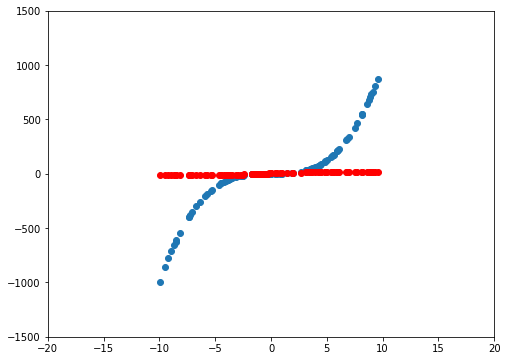

In [27]:
EPOCHS = 800

#trials = MongoTrials('mongo://localhost:27017/trials_poly/jobs', exp_key='experiment_1')
trials = Trials()
best = fmin(build_model_hopt, space, algo=tpe.suggest, max_evals = 3, trials=trials)


print('best_model_is ...')
print(best)

best_model = keras.Sequential()
best_model.add(keras.layers.Dense(unit_numbers[best['units_1']], 
                                  activation=unit_activations[best['units_1_activation']],
                                  input_shape=(post_train_data_0.shape[1],), kernel_constraint=maxnorm(3)))
best_model.add(keras.layers.Dropout(best['dropout_1']))
best_model.add(keras.layers.Dense(unit_numbers[best['units_2']], 
                                  activation=unit_activations[best['units_2_activation']], 
                                  kernel_constraint=maxnorm(3)))

if best['layers_number'] == 1:
    best_model.add(keras.layers.Dense(unit_numbers[best['units_3']], init = "glorot_normal")) 
    best_model.add(keras.layers.Dropout(best['dropout_3']))

if best['layers_number'] == 2:
    best_model.add(keras.layers.Dense(unit_numbers[best['units_4']], init = "glorot_normal")) 
    best_model.add(keras.layers.Dropout(best['dropout_4']))
    
if best['layers_number'] == 3:
    best_model.add(keras.layers.Dense(unit_numbers[best['units_5']], init = "glorot_normal")) 
    best_model.add(keras.layers.Dropout(best['dropout_5']))

best_model.add(keras.layers.Dense(1))


best_model.compile(loss='mse',
            optimizer=optimizers[best['optimizer']],
            metrics=['mae'])


best_model.fit(post_train_data_0, train_labels_0, epochs=EPOCHS,
                validation_split=0.2, verbose=1)

predicted_0 = best_model.predict(train_data_0).reshape(data_points, 1)


plt.figure(figsize=(8,6))

plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_0, train_labels_0_pre)
plt.scatter(train_data_0, predicted_0, c='red')

plt.savefig('best.eps', format='eps', dpi=1000)


In [31]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_263 (Dense)            (None, 8)                 16        
_________________________________________________________________
dropout_110 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_264 (Dense)            (None, 2)                 18        
_________________________________________________________________
dense_265 (Dense)            (None, 8)                 24        
_________________________________________________________________
dropout_111 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_266 (Dense)            (None, 1)                 9         
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [30]:
predicted_0 = best_model.predict(train_data_0).reshape(data_points, 1)
    
acc = np.sum(np.abs(predicted_0 - train_labels_0_pre))
print(acc)

2076390.4490338224


In [69]:
best

{'dropout_1': 1,
 'dropout_4': 2,
 'layers_number': 2,
 'optimizer': 0,
 'units_1': 23,
 'units_1_activation': 1,
 'units_2': 20,
 'units_2_activation': 0,
 'units_4': 13,
 'units_4_activation': 2}

In [27]:
test_data = np.random.uniform(10, 15, 3)
test_label = np.power(test_data, 3)

preds = best_model.predict(test_data).reshape(3, 1)
error = np.sum(np.abs(preds - test_label))
print(error)

16964.03078917429


### Old stuff

In [130]:
def build_model(train_data):
    model = keras.Sequential([
       keras.layers.Dense(2, input_shape=(train_data.shape[1],)),
       keras.layers.Dense(6, activation= tf.keras.activations.sigmoid, input_shape=(train_data.shape[1],)),
       keras.layers.Dense(1)
    ])

    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.5)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

In [131]:
model_0 = build_model(post_train_data_0)
model_0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_744 (Dense)            (None, 2)                 4         
_________________________________________________________________
dense_745 (Dense)            (None, 6)                 18        
_________________________________________________________________
dense_746 (Dense)            (None, 1)                 7         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


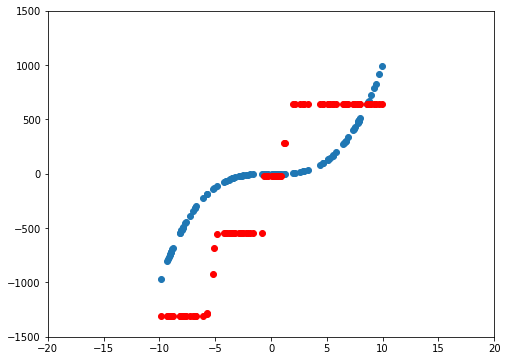

In [132]:
EPOCHS = 1500

# Store training stats
history_0 = model_0.fit(post_train_data_0, train_labels_0, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, batch_size=30)

predicted_0 = model_0.predict(train_data_0).reshape(data_points, 1)


plt.figure(figsize=(8,6))

plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_0, train_labels_0_pre)
plt.scatter(train_data_0, predicted_0, c='red')
plt.savefig('old.eps', format='eps', dpi=1000)


### A uniform distribution with Guassian noise (0, 50)

In [124]:
np.sum(np.abs(predicted_0 - train_labels_0_pre))

5496859.642109707

In [125]:
model_0.count_params()

21

In [137]:
train_data_1 = np.random.uniform(-10, 10, 100)

mu_train_1, sigma_train_1 = 0, 50
noise_train_1 = np.random.normal(mu_train_1, sigma_train_1, 100)

train_labels_1_pre = np.power(train_data_1, 3) + noise_train_1

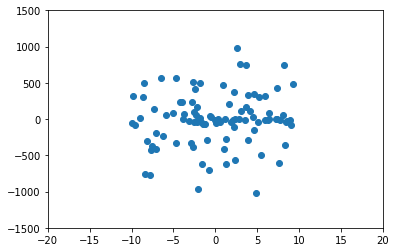

In [138]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_1)
plt.show()

In [141]:
order = np.argsort(np.random.random(train_labels_1.shape))

pre_train_data_1 = np.array(train_data_1[order]).reshape(100, 1)
train_labels_1 = np.array(train_labels_1_pre[order]).reshape(100, 1)

mean = pre_train_data_1.mean(axis=0)
std = pre_train_data_1.std(axis=0)

post_train_data_1 = (pre_train_data_1 - mean) / std

/Users/amirrahnama/anaconda3/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [142]:
model_1 = build_model(post_train_data_1)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [143]:
EPOCHS = 500

# Store training stats
history_1 = model_1.fit(post_train_data_1, train_labels_1, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

In [30]:
predicted = model_1.predict(train_data_1).reshape(100, 1)

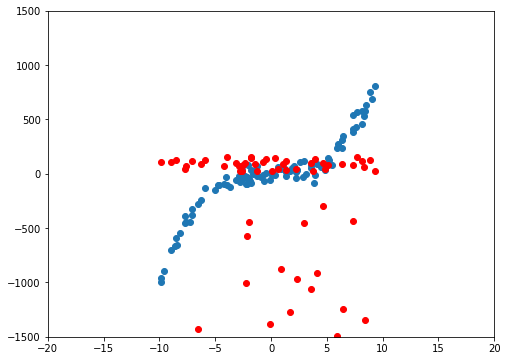

In [144]:
plt.figure(figsize=(8,6))

plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_1_pre)
plt.scatter(train_data_1, predicted, c='red')
plt.show()


### Add more data to the same model

In [84]:
mu_train_2, sigma_train_2 = 0, 100

noise_train_2 = np.random.normal(mu_train_2, sigma_train_2, 100)
train_labels_2 = np.power(train_data_1, 3) + noise_train_2

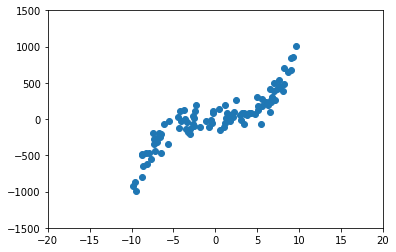

In [86]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_2)
plt.show()

In [87]:
order = np.argsort(np.random.random(train_labels_1.shape))
train_labels_2 = np.array(train_labels_2[order]).reshape(100, 1)

In [88]:
model_2 = build_model(post_train_data_1)
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [89]:
EPOCHS = 500

# Store training stats
history_2 = model_2.fit(post_train_data_1, train_labels_2, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

In [90]:
predicted_2 = model_2.predict(train_data_1).reshape(100, 1)

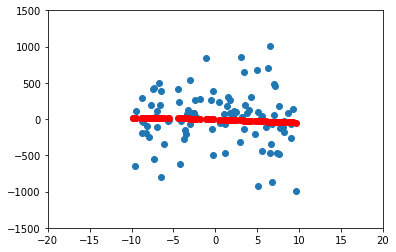

In [91]:
plt.xlim(-20, 20)
plt.ylim(-1500, 1500)
plt.scatter(train_data_1, train_labels_2)
plt.scatter(train_data_1, predicted_2, c='red')
plt.show()

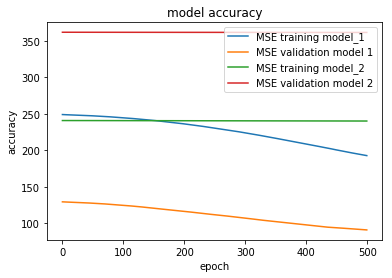

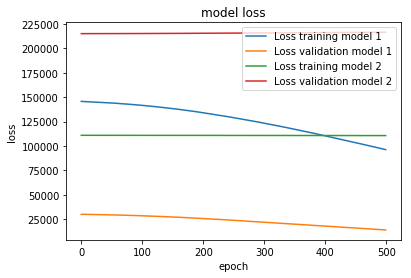

In [92]:
plt.plot(history_1.history['mean_absolute_error'], label= "MSE training model_1")
plt.plot(history_1.history['val_mean_absolute_error'], label= "MSE validation model 1")
plt.plot(history_2.history['mean_absolute_error'], label= "MSE training model_2")
plt.plot(history_2.history['val_mean_absolute_error'], label= "MSE validation model 2")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history_1.history['loss'], label="Loss training model 1")
plt.plot(history_1.history['val_loss'], label="Loss validation model 1")
plt.plot(history_2.history['loss'], label="Loss training model 2")
plt.plot(history_2.history['val_loss'], label="Loss validation model 2")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [52]:
x = train_data_0
y=train_labels_0_pre
z = np.polyfit(train_data_0, train_labels_0_pre, 10)
#p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(x, y, 20))

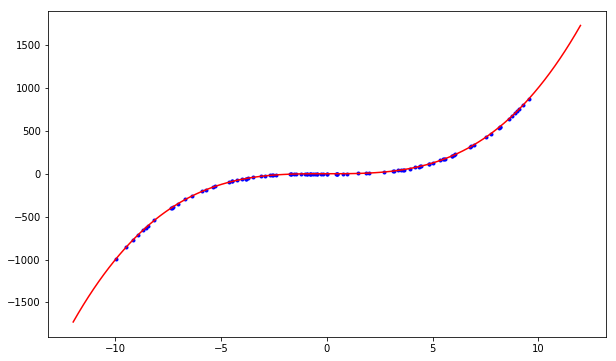

In [62]:
xp = np.linspace(-12, 12, 100)
plt.figure(figsize=(10,6))
#plt.plot(x, y, '.', xp, p(xp), '-', xp, p30(xp), '--', c)
plt.plot(x, y, '.', c="blue")
plt.plot(xp, p(xp), '-', c="red")
#plt.plot(xp, p30(xp), '--', c="red")
plt.savefig('curve_fitting.eps', format='eps', dpi=1000)

In [94]:
np.mean(history_2.history['mean_absolute_error'])

240.6719835479736

In [80]:
model_1.count_params()

193

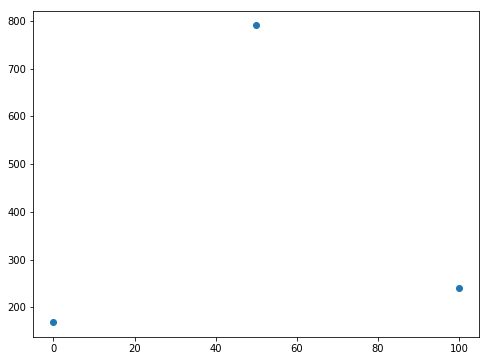

In [132]:
x = [np.mean(history_0.history['mean_absolute_error']), 
     np.mean(history_1.history['mean_absolute_error']), 
     np.mean(history_2.history['mean_absolute_error'])]

y = [sigma_train_0, sigma_train_1, sigma_train_2]

plt.figure(figsize=(8,6))

plt.scatter(y, x)
plt.show()